# RNN,  LSTM vizual plot

In [1]:
# !pip install Keras
# !pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.fftpack import fft
from scipy import signal
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import io
import pandas as pd
import numpy as np
import matplotlib  as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler 

In [2]:
%matplotlib inline
dfx=pd.read_csv('data_zero.csv')
calculation_speed = 100
dfx[::calculation_speed]

,miliseka,P20113,P20110,P10216,P10215,P10116,P10115,P10110,P7500
0,1.366789e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100,1.366789e+12,-0.016565,-0.021564,0.003126,0.006878,-0.014059,-0.012186,-0.004062,-0.005625
200,1.366789e+12,-0.001566,-0.009378,-0.001251,0.003441,-0.012184,-0.012814,0.000937,0.006875
300,1.366789e+12,0.008438,0.003124,0.000313,0.004377,-0.009686,-0.010000,-0.002812,-0.003125
400,1.366789e+12,0.013123,0.007496,-0.010313,-0.009060,-0.005938,-0.005001,0.001875,0.008125
...,...,...,...,...,...,...,...,...,...
107500,1.366790e+12,0.045933,0.050312,0.037500,0.043442,0.016251,0.013124,0.008125,0.006562
107600,1.366790e+12,0.048124,0.052496,0.044687,0.047501,0.017189,0.019064,0.006875,0.005312
107700,1.366790e+12,0.043432,0.044683,0.038126,0.047813,0.011877,0.015938,0.000313,0.001875
107800,1.366790e+12,0.039997,0.034372,0.035311,0.041565,0.019377,0.025000,0.002812,0.005938


In [3]:
# **Why is do we have 3 values as inputs?**

# We will see latter that RNNs, LTSMs require 3D input for the X values. This is often very confusing for beginners and people who return back to the field after a break (make sure you remember this, because even if you are an employeed data scientist you might not work with RNNs and forget this information, which is fundamental to understanding of RNNs). What are those 3 dimensions:

# - **Samples / how many sequences**. One sequence is one sample. A batch is comprised of one or more samples (batch size not specified).
# - **Time Steps / how many values in each sample**. One time step is one point of observation in the sample.
# - **Features / collumn count**. One feature is one observation at a time step. This is essentially how many values at each time step you have.

# Say we want to feed this into our network:

In [4]:
def taking_of_nan_values_DF(df):
    print("taking_of_nan_values_DF(df)")
    # interpolation
    df = df.interpolate(method='linear', limit_direction='forward', axis=0)
    # taking of nullmi
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

In [5]:
df = pd.DataFrame(dfx[::calculation_speed])
df = taking_of_nan_values_DF(pd.DataFrame(df))
df

taking_of_nan_values_DF(df)


,miliseka,P20113,P20110,P10216,P10215,P10116,P10115,P10110,P7500
0,1.366789e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100,1.366789e+12,-0.016565,-0.021564,0.003126,0.006878,-0.014059,-0.012186,-0.004062,-0.005625
200,1.366789e+12,-0.001566,-0.009378,-0.001251,0.003441,-0.012184,-0.012814,0.000937,0.006875
300,1.366789e+12,0.008438,0.003124,0.000313,0.004377,-0.009686,-0.010000,-0.002812,-0.003125
400,1.366789e+12,0.013123,0.007496,-0.010313,-0.009060,-0.005938,-0.005001,0.001875,0.008125
...,...,...,...,...,...,...,...,...,...
107500,1.366790e+12,0.045933,0.050312,0.037500,0.043442,0.016251,0.013124,0.008125,0.006562
107600,1.366790e+12,0.048124,0.052496,0.044687,0.047501,0.017189,0.019064,0.006875,0.005312
107700,1.366790e+12,0.043432,0.044683,0.038126,0.047813,0.011877,0.015938,0.000313,0.001875
107800,1.366790e+12,0.039997,0.034372,0.035311,0.041565,0.019377,0.025000,0.002812,0.005938


In [6]:
def plot_learning_curves(loss):
    print("plot_learning_curves(loss)")
    plt.figure(figsize=(14,5))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)  


In [7]:
def RNN2(new_dataset, valid_data, interval_to_train, column, scaler, lstm_model, parameter):      
    # construct the dataset for prediction
    inputs_data=new_dataset[len(new_dataset)-len(valid_data)-parameter:].values
    inputs_data=inputs_data.reshape(-1,1)
    inputs_data=scaler.transform(inputs_data)
    X_test=[]
    for i in range(parameter,inputs_data.shape[0]):
        X_test.append(inputs_data[i-parameter:i,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

    predicted_closing_price=lstm_model.predict(X_test)
#     print(predicted_closing_price)
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
#     print(predicted_closing_price)

    train_data=new_dataset[:interval_to_train]
    valid_data=new_dataset[interval_to_train:]
    valid_data = valid_data.assign(Predictions=predicted_closing_price)
    plt.figure(figsize=(14,5))
    plt.plot(new_dataset[str(column)])    
    plt.title('RNN LSTM ' + str(column), size=12)
    plt.plot(valid_data.index, predicted_closing_price)
    plt.show()
    # Calculate the MSE for predictions
    from sklearn.metrics import mean_squared_error
    mean_squared_error(valid_data[str(column)],predicted_closing_price) 
   # Increase the epoch count and retrain the network, see if MSE improves

In [8]:
def RNN(df):
    columns = df.columns
    print("Starting RNN(df)")
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]], unit='ms')
    import datetime    
    rows = len(df)
    # parameters
    parameter = 10
    number_of_epochs = 10
    number_of_batch_size = 100
    interval_to_train = int(rows/2)

    columns = df.columns
    for column in columns:
        if column != df.columns[0]:

            print(column)
            df['Date'] = df[df.columns[0]]
            # Timestamp('2017-03-22 15:16:45.433502912')
            df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
            df.index=df['Date']
            
            data=df.sort_index(ascending=True,axis=0)
            new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date',str(column)])

            for i in range(0,len(data)):
                new_dataset["Date"][i]=data['Date'][i]
                new_dataset[str(column)][i]=data[str(column)][i]

            train_data = new_dataset[0:interval_to_train]
            valid_data = new_dataset[interval_to_train:]

            new_dataset.index=new_dataset.Date
            new_dataset.drop("Date",axis=1,inplace=True)

            new_dataset.tail(5)

            scaler=MinMaxScaler(feature_range=(0,1))
            scaled_data=scaler.fit_transform(new_dataset)

            # construct the sequences: we will try to predict y
            # ... based on last parameter values of x
            x_train_data, y_train_data=[],[]
            for i in range(parameter,len(train_data)):
                x_train_data.append(scaled_data[i-parameter:i,0])
                y_train_data.append(scaled_data[i,0])

            # convert to numpy
            x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
            print(x_train_data.shape)

            # reshape it to 3D
            x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

            # to see how the shape changes we can again print it out
            lstm_model=Sequential()
            lstm_model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train_data.shape[1],1)))
            lstm_model.add(LSTM(units=50))
            lstm_model.add(Dense(1))
            lstm_model.compile(loss='mean_squared_error',optimizer='adam')
            
            history = lstm_model.fit(x_train_data,y_train_data, epochs=number_of_epochs, batch_size=number_of_batch_size,verbose=1)
            
            plot_learning_curves(history.history["loss"])
            plt.show()
            
            RNN2(new_dataset, valid_data, interval_to_train, column, scaler, lstm_model, parameter)
          
           # Increase the epoch count and retrain the network, see if MSE improves


Starting RNN(df)
P20113
(530, 10)
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 8ms/step - loss: 0.1547
Epoch 2/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0237
Epoch 3/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0293
Epoch 4/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0134
Epoch 5/10
6/6 [====================

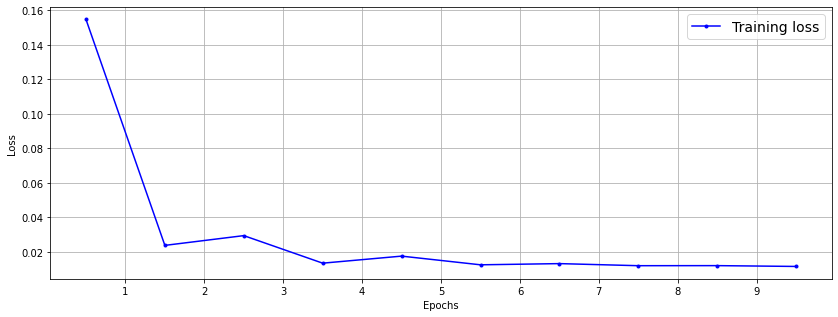

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


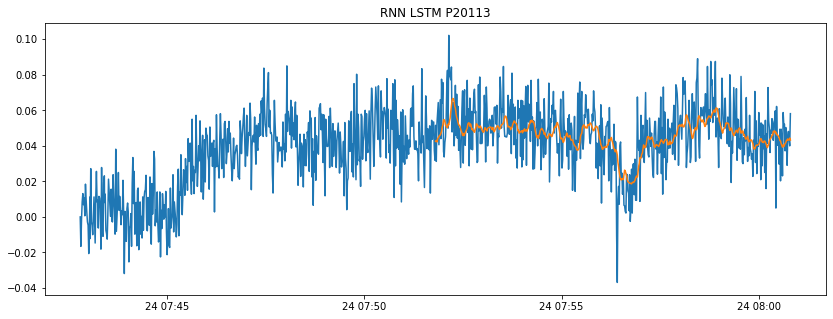

P20110
(530, 10)
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 7ms/step - loss: 0.1592
Epoch 2/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 3/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0287
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.0138
Epoch 5/10
6/6 [==============================] - 0s 

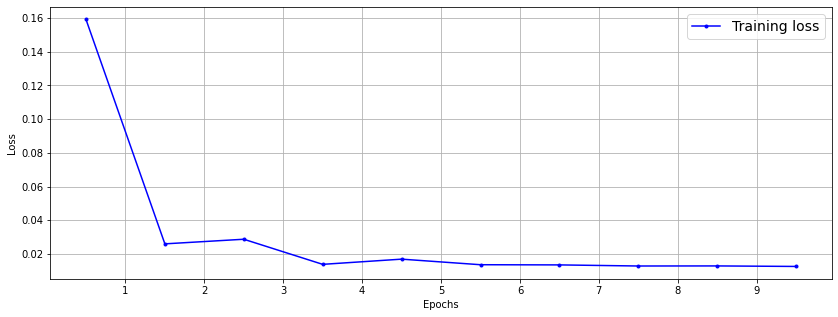

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


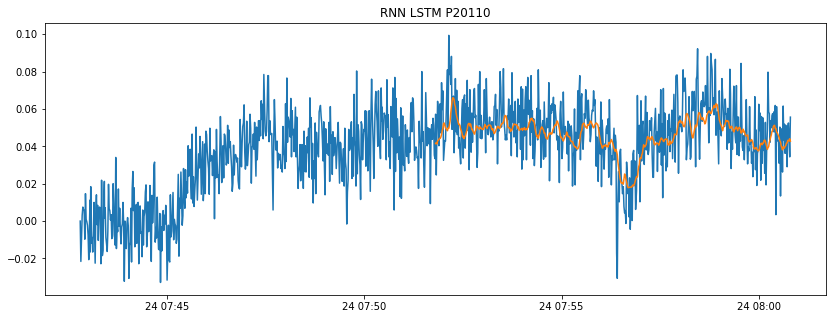

P10216
(530, 10)
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 8ms/step - loss: 0.3655
Epoch 2/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0387
Epoch 3/10
6/6 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 4/10
6/6 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 5/10
6/6 [==============================] - 0s 

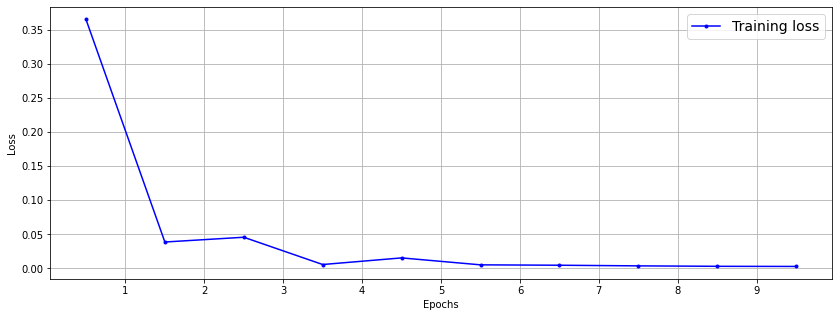

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


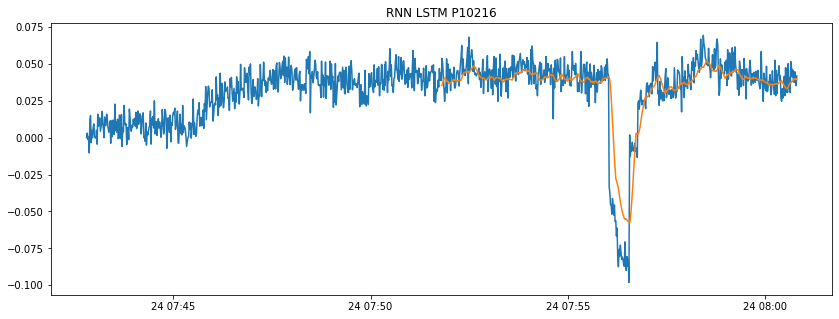

P10215
(530, 10)
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 8ms/step - loss: 0.3804
Epoch 2/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 3/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0454
Epoch 4/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 5/10
6/6 [==============================] - 0s 

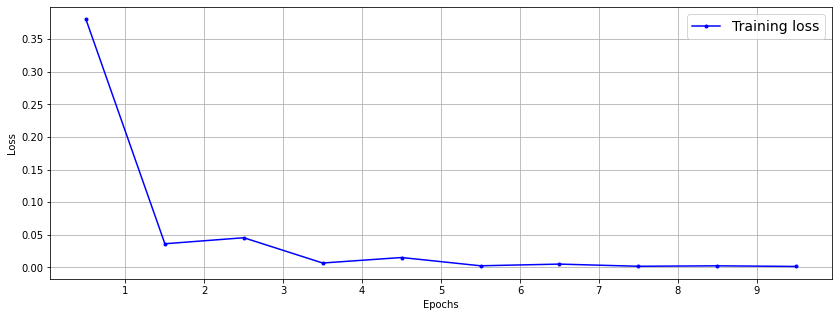

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


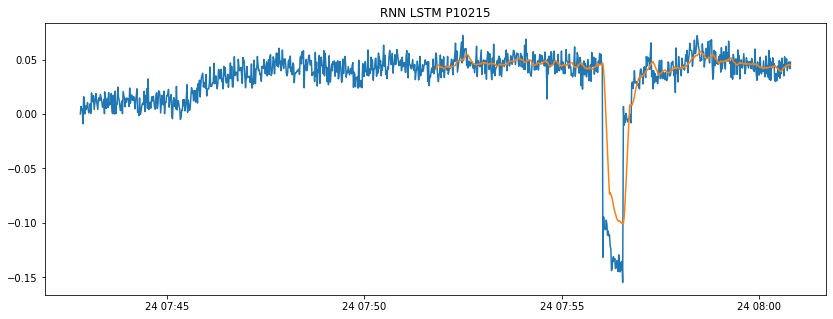

P10116
(530, 10)
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 8ms/step - loss: 0.4504
Epoch 2/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0810
Epoch 3/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0430
Epoch 4/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 5/10
6/6 [==============================] - 0s 

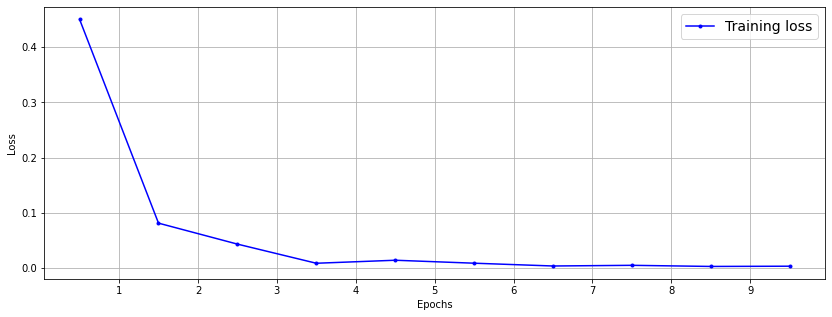

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


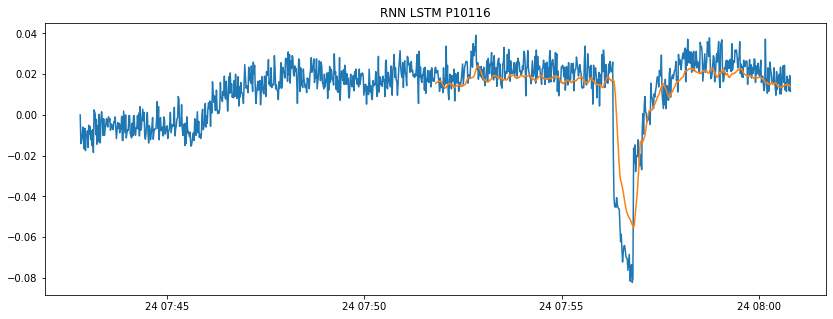

P10115
(530, 10)
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 9ms/step - loss: 0.4593
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 0.1310
Epoch 3/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0235
Epoch 4/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 5/10
6/6 [==============================] - 0s 

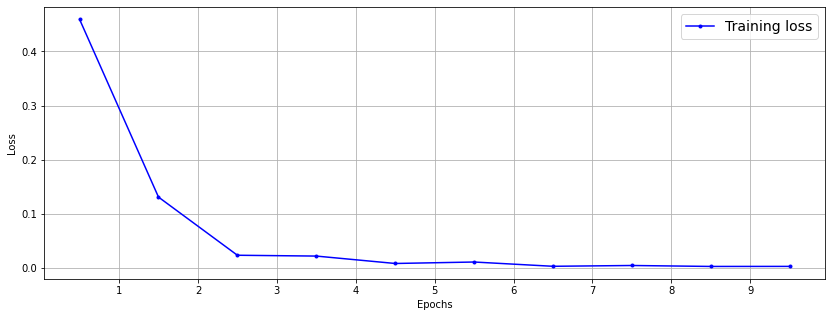

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


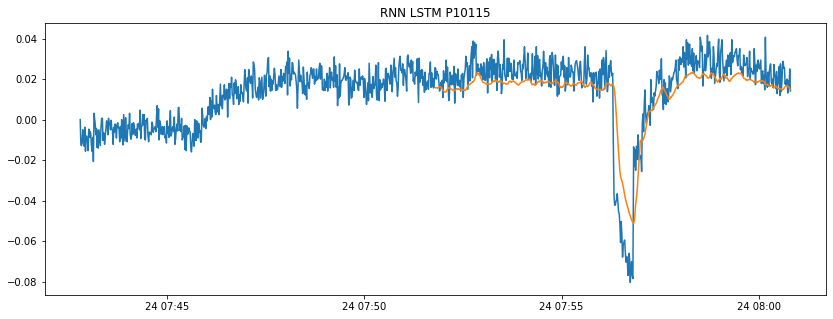

P10110
(530, 10)
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 10ms/step - loss: 0.1754
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0212
Epoch 3/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 4/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 5/10
6/6 [==============================] - 0s

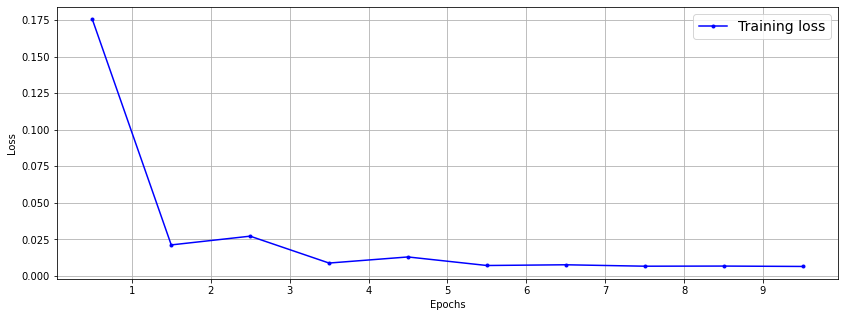

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


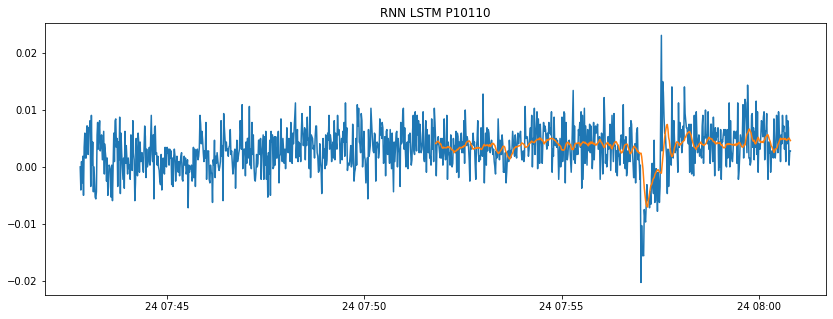

P7500
(530, 10)
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 0s 10ms/step - loss: 0.3726
Epoch 2/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0907
Epoch 3/10
6/6 [==============================] - 0s 6ms/step - loss: 0.0209
Epoch 4/10
6/6 [==============================] - 0s 7ms/step - loss: 0.0207
Epoch 5/10
6/6 [==============================] - 0s 

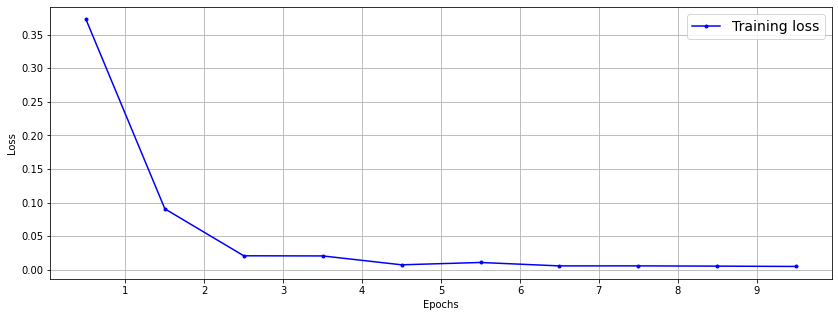

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


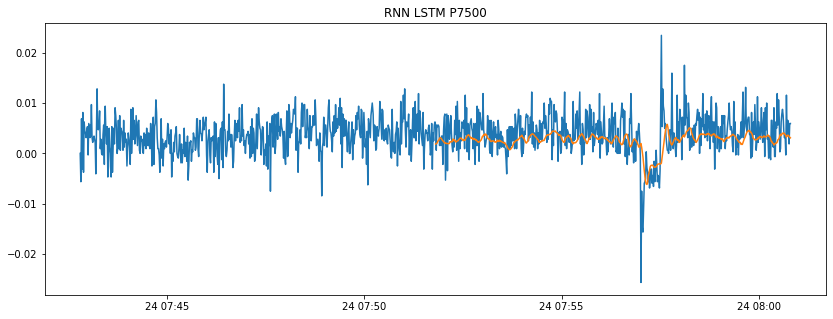

In [9]:
RNN(df)